(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [18]:
# Load project package
@load_pkg Antibiotic

import Revise
# Import project package
import Antibiotic

# Import package to save outputs
import BSON

# Import basic math
import LinearAlgebra

# Import clustering algorithms
import Clustering

# Import ML libraries
import Flux
import Zygote

# Import differential equations solver
import DifferentialEquations as DiffEq

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
Antibiotic.viz.pboc_makie!()

# Differential geometry of latent space

`[explanation here]`

### Training simple autoencoder

Given this 3D data, we can train an autoencoder with a 2D latent space. This
training was done with the `SimpleChains.jl` library. Let's import the results.

In [2]:
# Define number of epohcs
n_epoch = 500_000
# n_epoch = 2_000_000
# Define how often error should be computd
n_error = 5_000

# Define filename
fname = "$(git_root())/code/processing/ae_3Dpeak/output/$(n_epoch)_epoch/" *
        "ae_2dimensions.bson"
# Load model
ae = BSON.load(fname)[:ae]
# Load mean squared error
mse = BSON.load(fname)[:mse_flux]
# Load data
data = BSON.load(fname)[:data];
# Load standardized data
data_std = BSON.load(fname)[:data_std];

Let's look at the mean squared error over time as the training progresses.

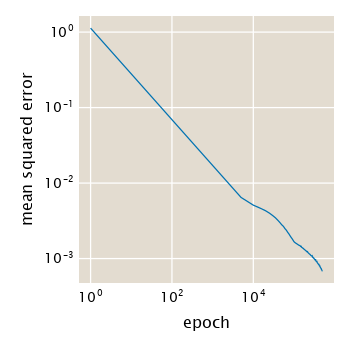

In [3]:
# Initialize figure
fig = Figure(resolution=(350, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="epoch",
    ylabel="mean squared error",
    yscale=log10,
    xscale=log10,
)

# Plot error
lines!(ax, [collect(1:n_error:n_epoch); [n_epoch]], mse)

fig

Everything looks normal with the training.

Let's look at the resemblance between the input and the output of this
autoencoder. For this, we will plot the true value of the function and the
autoencoder-reconstructed value side-to-side. To make sure that the
reconstruction keeps the structure of the data, we will color the points by
their true $z$-value dictated by our function $\underline{f}$ as well as by the
angle on the $x-y$-plane to make sure the autoencoder learned to distinguish the 
points despite the circular symmetry.

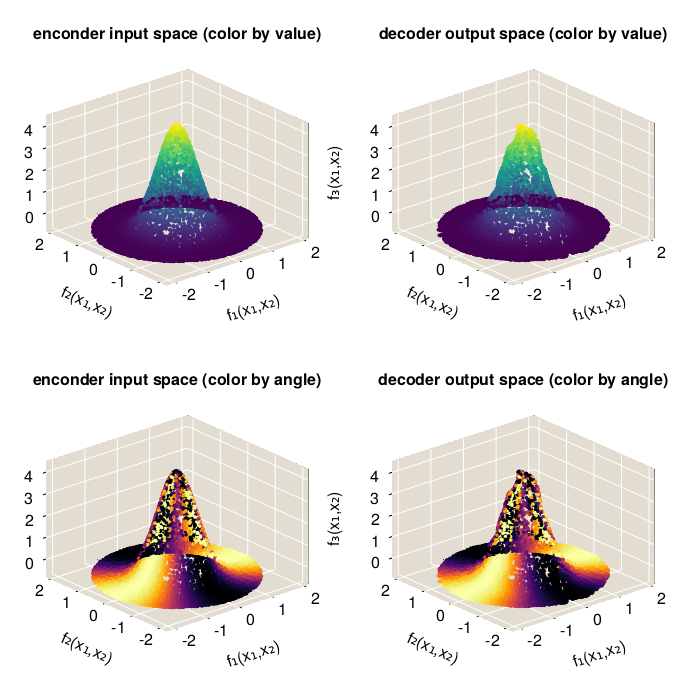

In [4]:
# Initialize figure
fig = Figure(resolution=(2 * 350, 2 * 350))

# Add GridLayout
gl = GridLayout(fig[1, 1])

ax = [
    Axis3(
        gl[i, j],
        xlabel="f₁(x₁,x₂)",
        ylabel="f₂(x₁,x₂)",
        zlabel="f₃(x₁,x₂)",
        xypanelcolor="#E3DCD0",
        xzpanelcolor="#E3DCD0",
        yzpanelcolor="#E3DCD0",
        xgridcolor=:white,
        ygridcolor=:white,
        zgridcolor=:white,
    ) for i = 1:2 for j = 1:2
]

# Reshape axis
ax = permutedims(reshape(ax, 2, 2), (2, 1))

# Plot output space (color by z-value)
scatter!(
    ax[1, 1],
    data_std[1, :],
    data_std[2, :],
    data_std[3, :],
    markersize=5,
    color=data_std[3, :],
    colormap=:viridis,
)

# Add title
ax[1, 1].title = "enconder input space (color by value)"

# Plot output space (color by angle)
scatter!(
    ax[2, 1],
    data_std[1, :],
    data_std[2, :],
    data_std[3, :],
    markersize=5,
    color= atan.(data_std[1, :].^2, data_std[2, :].^2),
    colormap=:inferno,
)

# Add title
ax[2, 1].title = "enconder input space (color by angle)"

# Pass data through autoencoder
data_ae = ae(data_std)

# Plot output space (color by z-value)
scatter!(
    ax[1, 2],
    data_ae[1, :],
    data_ae[2, :],
    data_ae[3, :],
    markersize=5,
    color=data_std[3, :],
    colormap=:viridis,
)

# Add title
ax[1, 2].title = "decoder output space (color by value)"

# Plot output space (color by angle)
scatter!(
    ax[2, 2],
    data_ae[1, :],
    data_ae[2, :],
    data_ae[3, :],
    markersize=5,
    color= atan.(data_std[1, :].^2, data_std[2, :].^2),
    colormap=:inferno,
)

# Add title
ax[2, 2].title = "decoder output space (color by angle)"


fig

The autoencoder is able to reproduce the data with high fidelity. With this
autoencoder in hand, let's split the enconder and decoder sections.

In [5]:
# Extract encoder
encoder = ae[1:4]

# Extract decoder section
decoder = ae[5:end]

Chain(
  Dense(2 => 20, sigmoid_fast),         # 60 parameters
  Dense(20 => 20, sigmoid_fast),        # 420 parameters
  Dense(20 => 20, sigmoid_fast),        # 420 parameters
  Dense(20 => 3),                       # 63 parameters
)                   # Total: 8 arrays, 963 parameters, 4.262 KiB.

Next, let's map the input data (3D points) into the latent space (2D points) via
the encoder. Again, we will plot the value, assigning color based on the input
$z$-value determined by our function.

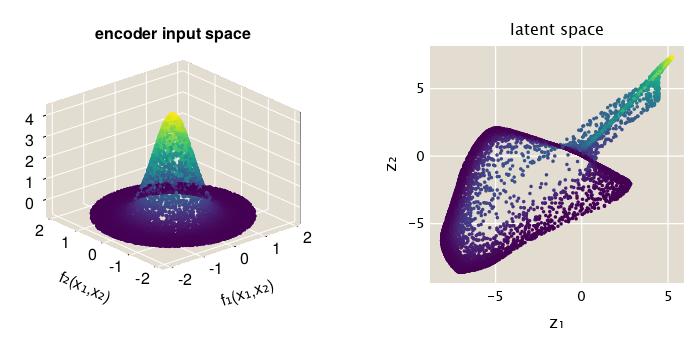

In [6]:
# Map input data to latent space
data_latent = encoder(data_std)

# Initialize figure
fig = Figure(resolution=(2 * 350, 350))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add axis for output space
ax_input = Axis3(
    gl[1, 1],
    xlabel="f₁(x₁,x₂)",
    ylabel="f₂(x₁,x₂)",
    zlabel="f₃(x₁,x₂)",
    title="encoder input space",
    xypanelcolor="#E3DCD0",
    xzpanelcolor="#E3DCD0",
    yzpanelcolor="#E3DCD0",
    xgridcolor=:white,
    ygridcolor=:white,
    zgridcolor=:white,
)

# Plot output space
scatter!(
    ax_input,
    data_std[1, :],
    data_std[2, :],
    data_std[3, :],
    markersize=5,
    color=data_std[3, :],
    colormap=:viridis,
)

# Add axis for latent space
ax_latent = Axis(
    gl[1, 2],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space"
)

# Plot latent space
scatter!(
    ax_latent,
    data_latent[1, :],
    data_latent[2, :],
    markersize=5,
    color=data_std[3, :],
    colormap=:viridis
)

# Separate axis
colgap!(gl, 50)

fig

### Computing the Riemmanian measure

`[explanation here]`

Let's define a grid of points on the $z_1-z_2$-plane on the latent space and
evaluate the measure, i.e., the square root of the determinant of the metric
tensor.

In [15]:
# Define numebr of points in range
n_range = 100

# Set range of values where to evaluate jacobian 
z1 = z2 = LinRange{Float32}(-8.5, 7.5, n_range)

# Initialize matrix to save metric
latent_measure = Matrix{Float32}(undef, n_range, n_range)

# Loop through first latent variable
for (i, x) in enumerate(z1)
    # Loop through second latent variable
    for (j, y) in enumerate(z2)
        # Compute the Riemmanian measure via the determinant of the metric
        # tensor
        latent_measure[i, j] = sqrt(
            LinearAlgebra.det(
                AutoEncode.diffgeo.riemmanian_metric(decoder, [x, y])
            )
        )
    end # for
end # for

Now, let's plot the this metric with and without the input data.

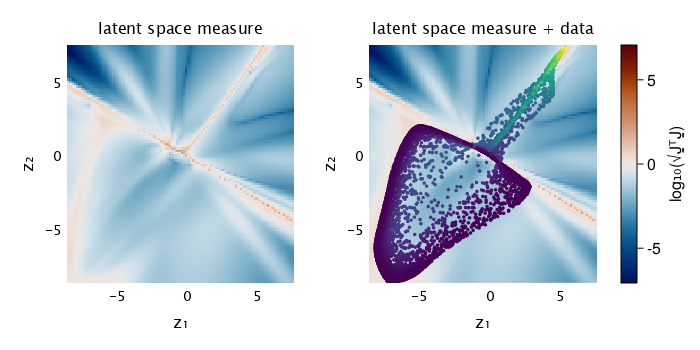

In [17]:
# Initialize figure
fig = Figure(resolution=(2 * 350, 350))

# Add axis for latent space
ax1 = Axis(
    fig[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space measure"
)

# Define range of values
colorrange = (
    - maximum(
        abs.([minimum(log10.(latent_measure)), maximum(log10.(latent_measure))])
    ),
    maximum(
        abs.([minimum(log10.(latent_measure)), maximum(log10.(latent_measure))])
    )
)
# Plot metric as a heatmap
hm = heatmap!(
    ax1, z1, z2, log10.(latent_measure), colormap=:vik, colorrange=colorrange
)


# Add axis for latent space
ax2 = Axis(
    fig[1, 2],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space measure + data"
)

# Plot metric as a heatmap
heatmap!(
    ax2, z1, z2, log10.(latent_measure), colormap=:vik, colorrange=colorrange
)

# Plot latent space
scatter!(
    ax2,
    data_latent[1, :],
    data_latent[2, :],
    markersize=5,
    color=data_std[3, :],
    colormap=:viridis
)

# Add colorbar
Colorbar(fig[:, end+1], hm, label="log₁₀(√J̲̲ᵀJ̲̲)") 

fig

We can see that the measure does not have the desired characteristic of being
contained within the data domain.

# Fitting a Radial Basis Function (RBF) network

In [21]:
# Cluster data using k-means
latent_kmeans = Clustering.kmeans(data_latent, 100)

latent_kmeans.centers

2×100 Matrix{Float32}:
 -7.78616  1.33485  -2.14499  -5.7821   …  -3.78441  -0.339837   1.03297
 -5.48176  2.00866   1.02077   1.16846     -5.28675   0.337948  -0.800574

Let's define the 

In [22]:
Clustering.assignments(latent_kmeans)

10000-element Vector{Int64}:
 99
  8
 69
 27
 56
 96
 25
 22
 27
 46
  ⋮
 42
 48
 57
 19
  3
 54
 31
 32
 46